In [1]:
import numpy as np
import matplotlib.pylab as plt
from numpy import linalg as LA
import sgd

In [2]:
token_number, dict_title, dict_text, dict_incorrect_text = sgd.read_source("test-2.csv")

In [3]:
#stratify sample on validation and train set
val_keys = list(dict_text.keys())[-1520:]
train_keys = list(dict_text.keys())[0:-1520]

dict_title_val = {idx: dict_title.get(item) for idx, item in enumerate(val_keys)}
dict_text_val =  dict = {idx: dict_text.get(item) for idx, item in enumerate(val_keys)}
dict_text = {item: dict_text.get(item) for item in train_keys}
dict_title = {item: dict_title.get(item) for item in train_keys}
dict_incorrect_text = {item: dict_incorrect_text.get(item) for item in train_keys}

In [4]:
embed_size = 300
mtx_embed =np.random.randn(len(token_number), embed_size).astype(np.float32) * 1e-6
mtx_grad = np.full_like(mtx_embed, 1e-8, dtype=np.float32)

In [5]:
#build epoch
epoch = 20
learning_rate = 0.1
good_quality = 0.8
metric_res = {}
for i in range(epoch):
    for idx in range(len(dict_text)):
        title_indices = dict_title[idx]
        text_indices = dict_text[idx]
        incor_text_indices = dict_incorrect_text[idx]
        title_vec = sgd.doc_to_vec(title_indices, mtx_embed)
        text_vec = sgd.doc_to_vec(text_indices, mtx_embed)
        incor_text_vec = sgd.doc_to_vec(incor_text_indices, mtx_embed)

        loss = sgd.calculate_loss(title_vec, text_vec, incor_text_vec)
        grad_anchor, grad_truth, grad_wrong = sgd.calculate_gradient(title_vec, text_vec, incor_text_vec)
    
        #add vector to every row of matrix
        #update accumulative matrix of gradient - keep it, it has influence on learning rate, if our parameter was changed a lot, it has less changes in future as learning rate will be decreased 
        mtx_grad[title_indices] += np.square(grad_anchor)/len(title_indices)
        mtx_grad[text_indices] += np.square(grad_truth)/len(text_indices)
        mtx_grad[incor_text_indices] += np.square(grad_wrong)/len(incor_text_indices)

        #update matrix of embeddings
        mtx_embed[title_indices] -= (learning_rate * grad_anchor/np.sqrt(mtx_grad[title_indices]))
        mtx_embed[text_indices] -= (learning_rate * grad_truth/np.sqrt(mtx_grad[text_indices]))
        mtx_embed[incor_text_indices] -= (learning_rate * grad_wrong/np.sqrt(mtx_grad[incor_text_indices]))

    #calculate the metric in the end of epoch
    # we need validation set for it - now get last 10 docs
    #number docs on dictionary - 1 and 0 / on number words in doc
    number_of_docs = len(dict_title_val)
    mtx_title = sgd.get_document_term_sparse_mtx(dict_title_val, token_number)
    mtx_text = sgd.get_document_term_sparse_mtx(dict_text_val, token_number)
    mtx_title = (mtx_title/mtx_title.sum(axis=1))[:, np.newaxis]
    mtx_text = (mtx_text/mtx_text.sum(axis=1))[:, np.newaxis]
    mtx_title = mtx_title.dot(mtx_embed)
    mtx_text = mtx_text.dot(mtx_embed)
    #calculate matrix of title_indices and text_indices and multiply it, look on diag   
    res = mtx_title.dot(mtx_text.T)
    indexes = np.argmax(res, axis=1)
    counter = 0   
    for idx in range(number_of_docs):
        if (idx == indexes[idx]):
            counter += 1
    metric = counter/number_of_docs
    metric_res[i] = metric
    #criteria for early stop
    if(metric > good_quality):
        break;        




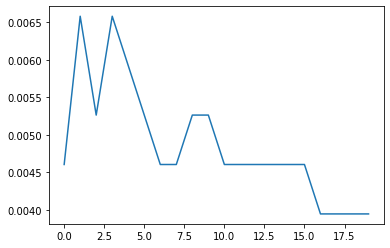

In [6]:
x, y = zip(*metric_res.items()) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.show()

In [7]:
mtx_title

matrix([[  5.4421955 ,  -1.7373425 ,   1.43631831, ...,   4.8000366 ,
           0.47950566,   2.89896708],
        [ -1.97534146,   4.19479803,  -3.8395173 , ...,   0.82559434,
          -5.46617508,   3.03338888],
        [  2.24744181, -11.38456049,  11.5548968 , ...,  -0.55829894,
          14.33150294,  -7.30689764],
        ...,
        [-10.85796181,  -6.85457865,   5.99761995, ..., -11.15495483,
           3.47317998,  -8.80698268],
        [  5.65702614,   5.73578446,  -4.79274439, ...,   6.81075638,
          -5.81879889,   5.04540909],
        [ -2.96617123,  -1.73913302,   0.79456488, ...,  -2.65210379,
           1.63446846,  -3.4652425 ]])

In [8]:
a = mtx_embed.dot(mtx_embed.T)
result = np.argmax(a, axis=1)

In [9]:
result

array([1013, 2034,   61, ...,   71,   71,   71])

In [10]:
list(token_number.keys())[list(token_number.values())[409]] 

'Reuters'

In [11]:
counter

6

In [12]:
counter = 0
for idx in range(number_of_docs):
    if idx == np.argmax(res, axis=1)[0]:
        counter += 1
